### **Data Characterization: Initial Dataset**

In [5]:
import sqlite3
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re


DB_PATH_DEDUPLICATED = "data/steam_games_raw_merged.db"
DB_PATH_USELESS_INFO = "data/steam_games_useless.db"
DB_PATH_PROCESSED = "data/steam_games_final.db"

In [6]:
# Common Functions
def db_to_pandas(path):
    conn = sqlite3.connect(path)
    db_cur = conn.cursor()
    standardize_nulls(conn,db_cur)
    query = "SELECT * From Game"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def output_nulls_info(df):
    print(f"Total Entries - {len(df)}")
    null_values = df.isnull().sum()
    total_rows = len(df)

    null_percentage = (null_values / total_rows) * 100

    result_df = pd.DataFrame({'Null Values': null_values, 'Null Percentage': null_percentage})
    result_df_sorted = result_df.sort_values(by='Null Values', ascending=False)

    print(result_df_sorted)
    
def standardize_nulls(conn, db_cur):
    """Parse all columns so null values have the same representation

    Args:
        conn: database connection
        db_cur: database cursor
    """
    
    query = f"select name from pragma_table_info('Game');"
    db_cur.execute(query)
    result = db_cur.fetchall()
    result = [x[0] for x in result]
    
    for column in result:
        update_query = f'''
                        UPDATE Game
                        SET {column} = null
                        WHERE {column} = '' or {column} = '-';
                        '''
        db_cur.execute(update_query)

    conn.commit()


In [7]:
print(f"Initial Entries {81048}")
#df_merged_deduplicated = db_to_pandas(DB_PATH_DEDUPLICATED)
#df_rm_useless = db_to_pandas(DB_PATH_USELESS_INFO)
df_processed = db_to_pandas(DB_PATH_PROCESSED)

Initial Entries 81048


#### Data-Set Information After Deduplication

In [8]:
#output_nulls_info(df_merged_deduplicated)

Approximately 160 entries because they were duplicated. (Same URL)

As we can see there are lots of null values, especially on publisher and description.

#### Removal of pointless entries
Since our dataset has a huge amount of entries and the goal of this project is to create a search engine regarding games, we thought it would be appropriate to remove entries that are DLC's, SoundTracks & SpecialEditions. Due to the fact that retrieving information from API's is a heavy process, we also removed entries that had a high amount of nulls.

In [9]:
#output_nulls_info(df_rm_useless)

As we can see almost 30k entries were removed (DLC's, Soundtracks & SpecialEditions).

#### Processed Dataset

In [10]:
output_nulls_info(df_processed)

Total Entries - 48219
              Null Values  Null Percentage
all_reviews          6532        13.546527
price                 677         1.404011
developer              82         0.170057
desc                   65         0.134802
requirements           42         0.087103
date                   41         0.085029
full_desc              29         0.060142
url                     0         0.000000
name                    0         0.000000
categories              0         0.000000


#### Wordcloud Processed Dataset

In [11]:
txt = ""
for x in df_processed['full_desc']:
    if not x: continue
    txt += x


#wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(txt)

#plt.figure(figsize=(10, 5))
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis('off')
#plt.show()


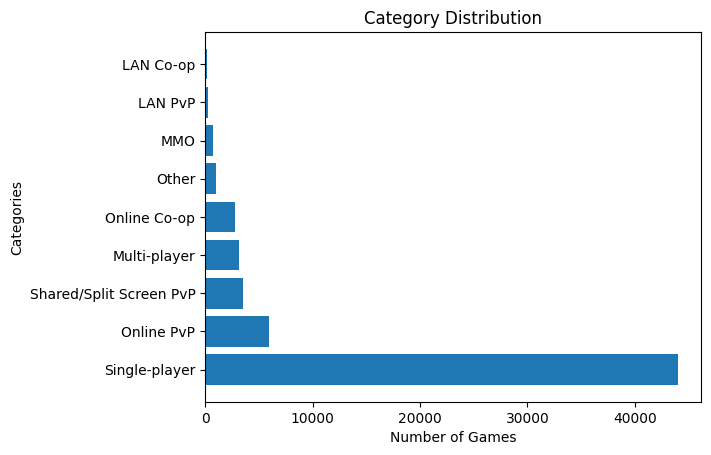

In [12]:
categories_df = df_processed['categories'].str.split(';', expand=True)
merged_df = pd.concat([df_processed['url'], categories_df], axis=1)

# Flatten the DataFrame and remove empty strings
category_counts = merged_df.iloc[:, 1:].stack().str.strip().value_counts()

# Exclude categories with empty string
category_counts = category_counts[category_counts.index != '']

# Plotting as a horizontal bar chart
plt.barh(category_counts.index, category_counts)
plt.xlabel('Number of Games')
plt.ylabel('Categories')
plt.title('Category Distribution')
plt.show()

#### Plot Game Releases vs Year

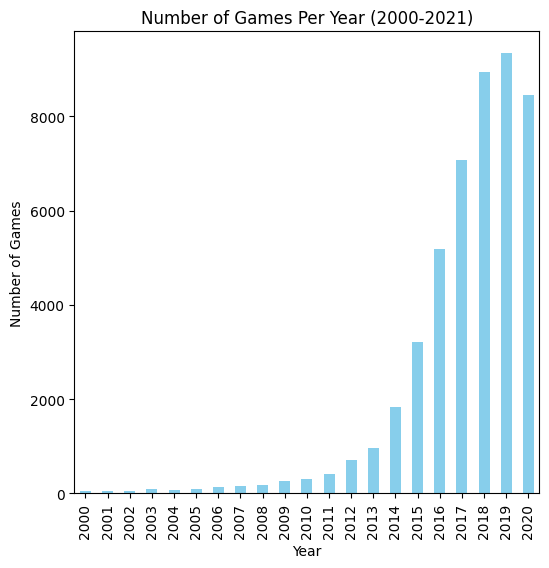

In [13]:
df_processed['year'] = df_processed['date'].str[-4:]
df_processed['year'] = pd.to_numeric(df_processed['year'], errors='coerce').astype('Int64')
games_per_year = df_processed['year'].value_counts().sort_index()

filtered_df = df_processed[(df_processed['year'] >= 2000) & (df_processed['year'] <= 2020)]

# Plotting
games_per_year = filtered_df['year'].value_counts().sort_index()
plt.figure(figsize=(6, 6))
games_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Games Per Year (2000-2021)')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.show()



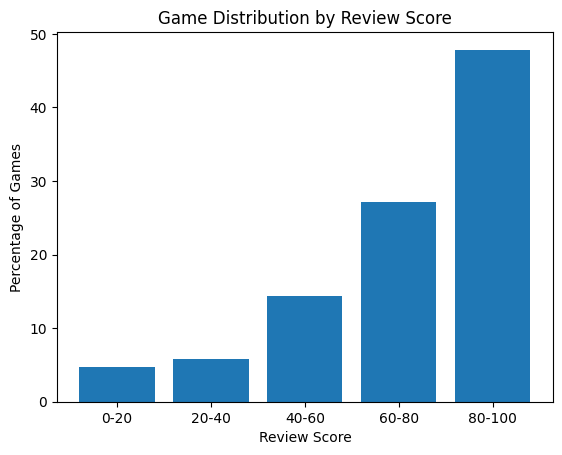

In [14]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']

# Create a new column for bins
df_processed['review_bins'] = pd.cut(df_processed['all_reviews'], bins=bins, labels=labels, include_lowest=True)

# Count the occurrences in each bin
review_counts = df_processed['review_bins'].value_counts().sort_index()

# Calculate percentages
review_percentages = (review_counts / review_counts.sum()) * 100

# Plotting with percentages on the y-axis
plt.bar(review_counts.index, review_percentages)
plt.xlabel('Review Score')
plt.ylabel('Percentage of Games')
plt.title('Game Distribution by Review Score')
plt.show()

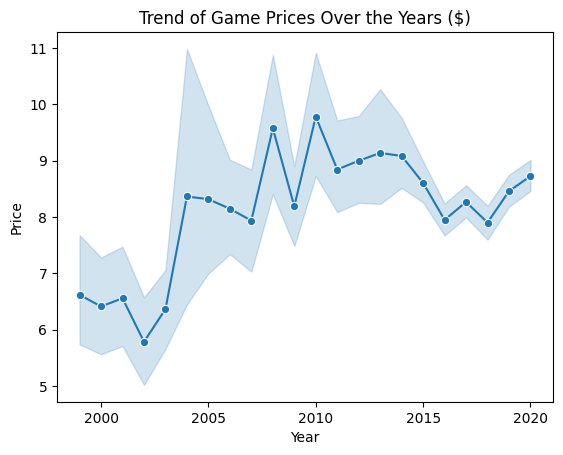

In [15]:
import seaborn as sns

def extract_year(date_str):
    try:
        return int(date_str[-4:])
    except (TypeError, ValueError):
        return None

df_processed['year'] = df_processed['date'].apply(extract_year)

# Modify the price column to be an integer (0 for free games)
df_processed['price'] = pd.to_numeric(df_processed['price'], errors='coerce').fillna(0).astype(int)

# Filter the DataFrame based on conditions
price_df = df_processed.dropna(subset=['year', 'price'])
price_df = price_df[(price_df['price'] != 0) & (price_df['year'] >= 1999) & (price_df['year'] <= 2020)]

# Plotting
sns.lineplot(x='year', y='price', data=price_df, marker='o')
plt.title('Trend of Game Prices Over the Years ($)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

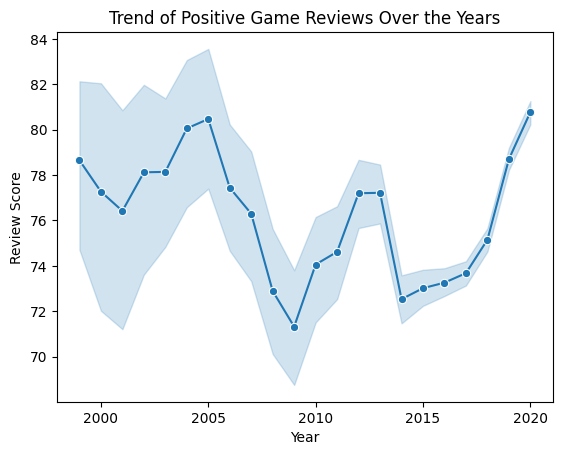

In [16]:
import seaborn as sns

def extract_year(date_str):
    try:
        return int(date_str[-4:])
    except (TypeError, ValueError):
        return None

df_processed['year'] = df_processed['date'].apply(extract_year)

# Modify the price column to be an integer (0 for free games)
df_processed['all_reviews'] = pd.to_numeric(df_processed['all_reviews'], errors='coerce').fillna(0).astype(int)

# Filter the DataFrame based on conditions
price_df = df_processed.dropna(subset=['year', 'all_reviews'])
price_df = price_df[(price_df['all_reviews'] != 0) & (price_df['year'] >= 1999) & (price_df['year'] <= 2020)]

# Plotting
sns.lineplot(x='year', y='all_reviews', data=price_df, marker='o')
plt.title('Trend of Positive Game Reviews Over the Years')
plt.xlabel('Year')
plt.ylabel('Review Score')
plt.show()

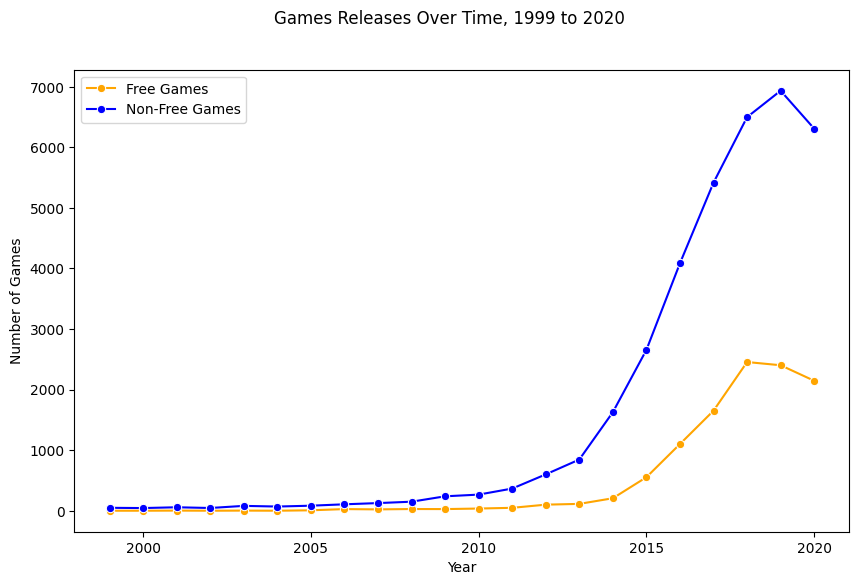

In [17]:

free_games_df = df_processed[df_processed['price'] == 0].groupby('year', as_index=False)['name'].count()
non_free_games_df = df_processed[df_processed['price'] > 0].groupby('year', as_index=False)['name'].count()

# Filter the DataFrames based on conditions
free_games_df = free_games_df[(free_games_df['year'].notnull()) & (free_games_df['year'] >= 1999) & (free_games_df['year'] <= 2020)]
non_free_games_df = non_free_games_df[(non_free_games_df['year'].notnull()) & (non_free_games_df['year'] >= 1999) & (non_free_games_df['year'] <= 2020)]

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='name', data=free_games_df, marker='o', label='Free Games', color='orange')
sns.lineplot(x='year', y='name', data=non_free_games_df, marker='o', label='Non-Free Games', color='blue')
plt.suptitle('Games Releases Over Time, 1999 to 2020')
plt.xlabel('Year')
plt.ylabel('Number of Games')
plt.legend(loc='best')
plt.show()
